/kaggle/input/north-oc-housing-data/north_county_oc - Sheet1.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


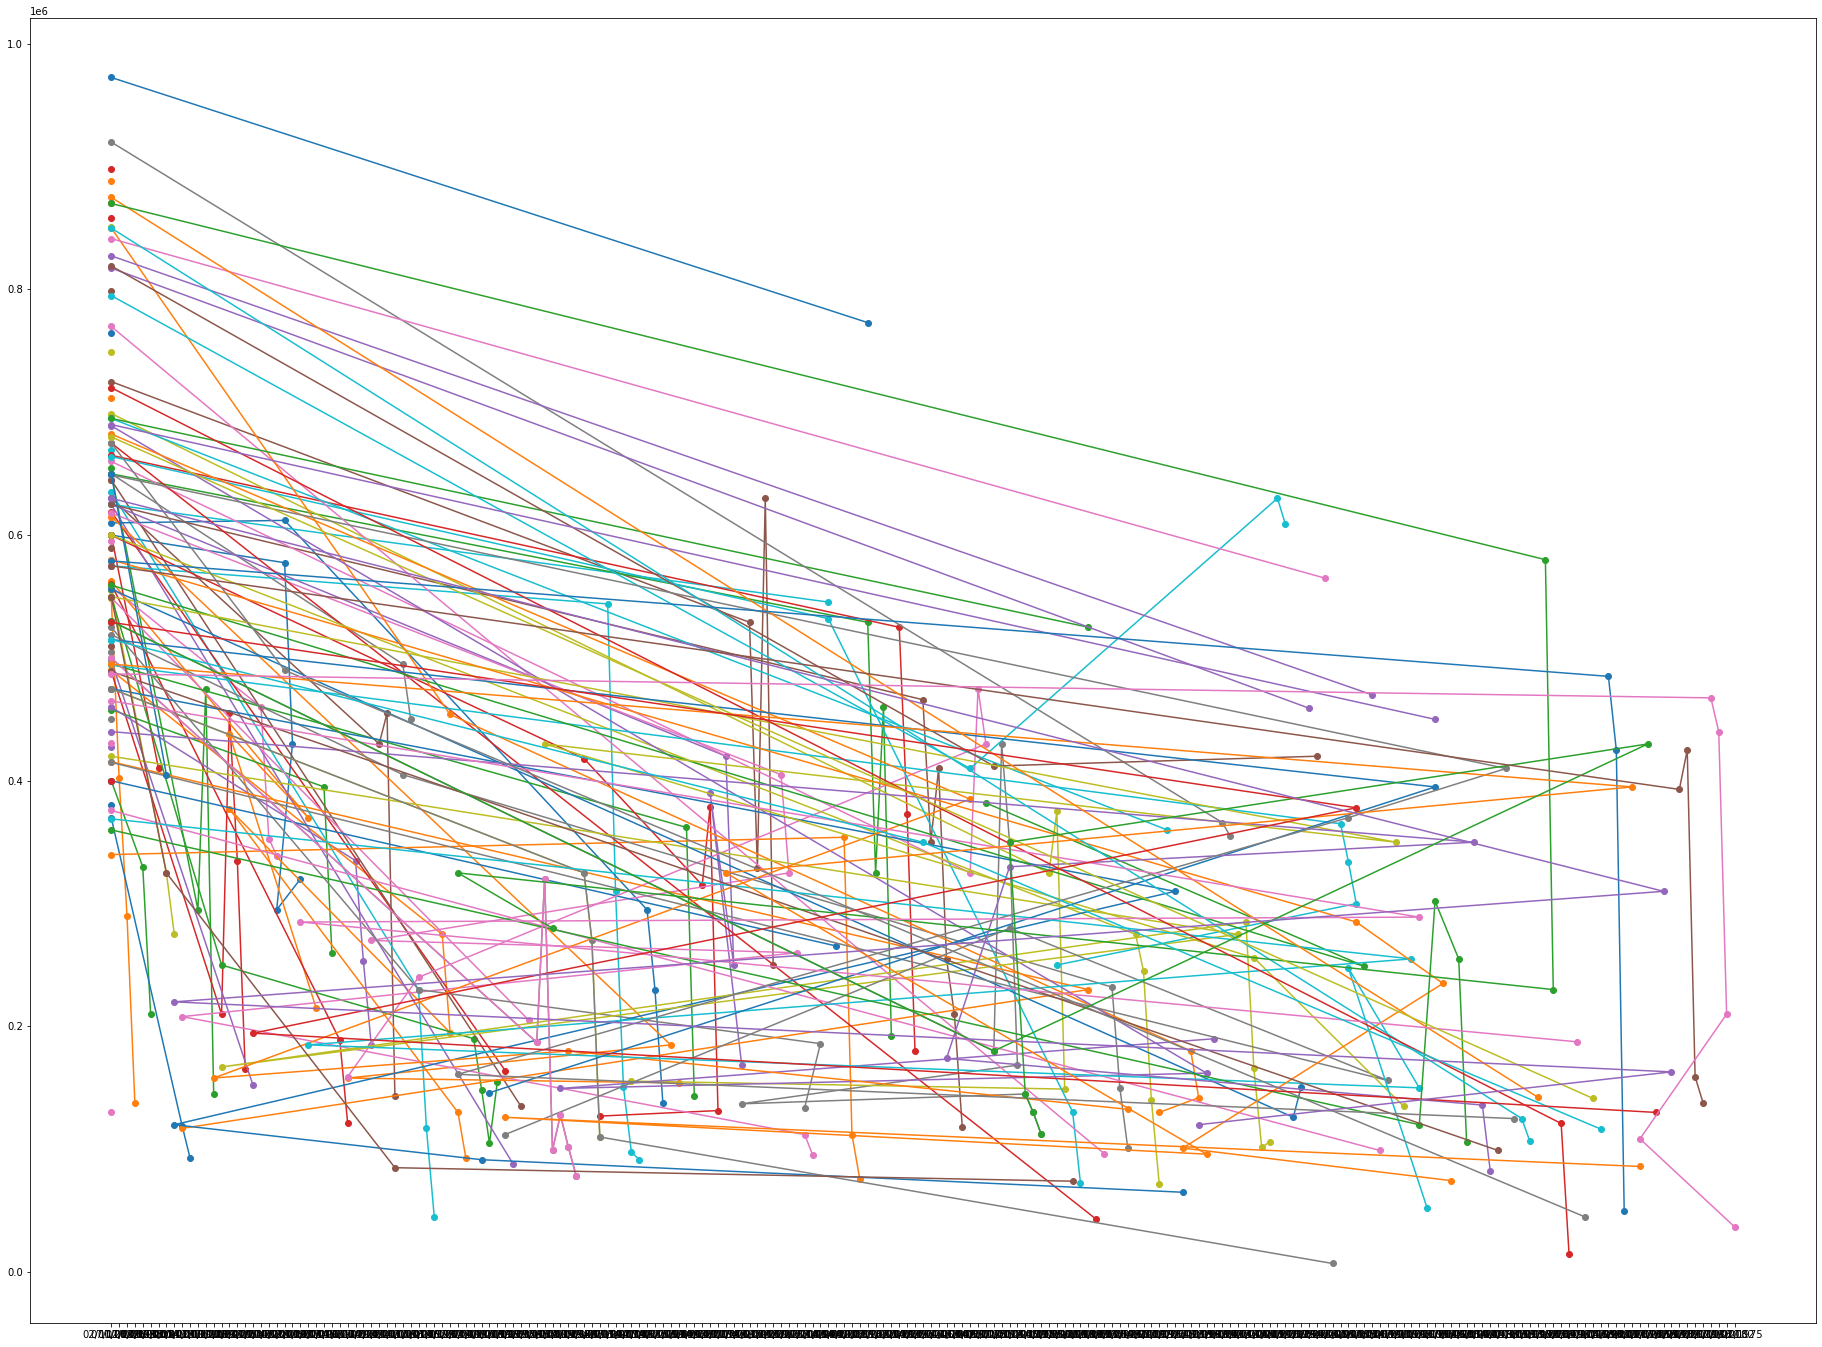

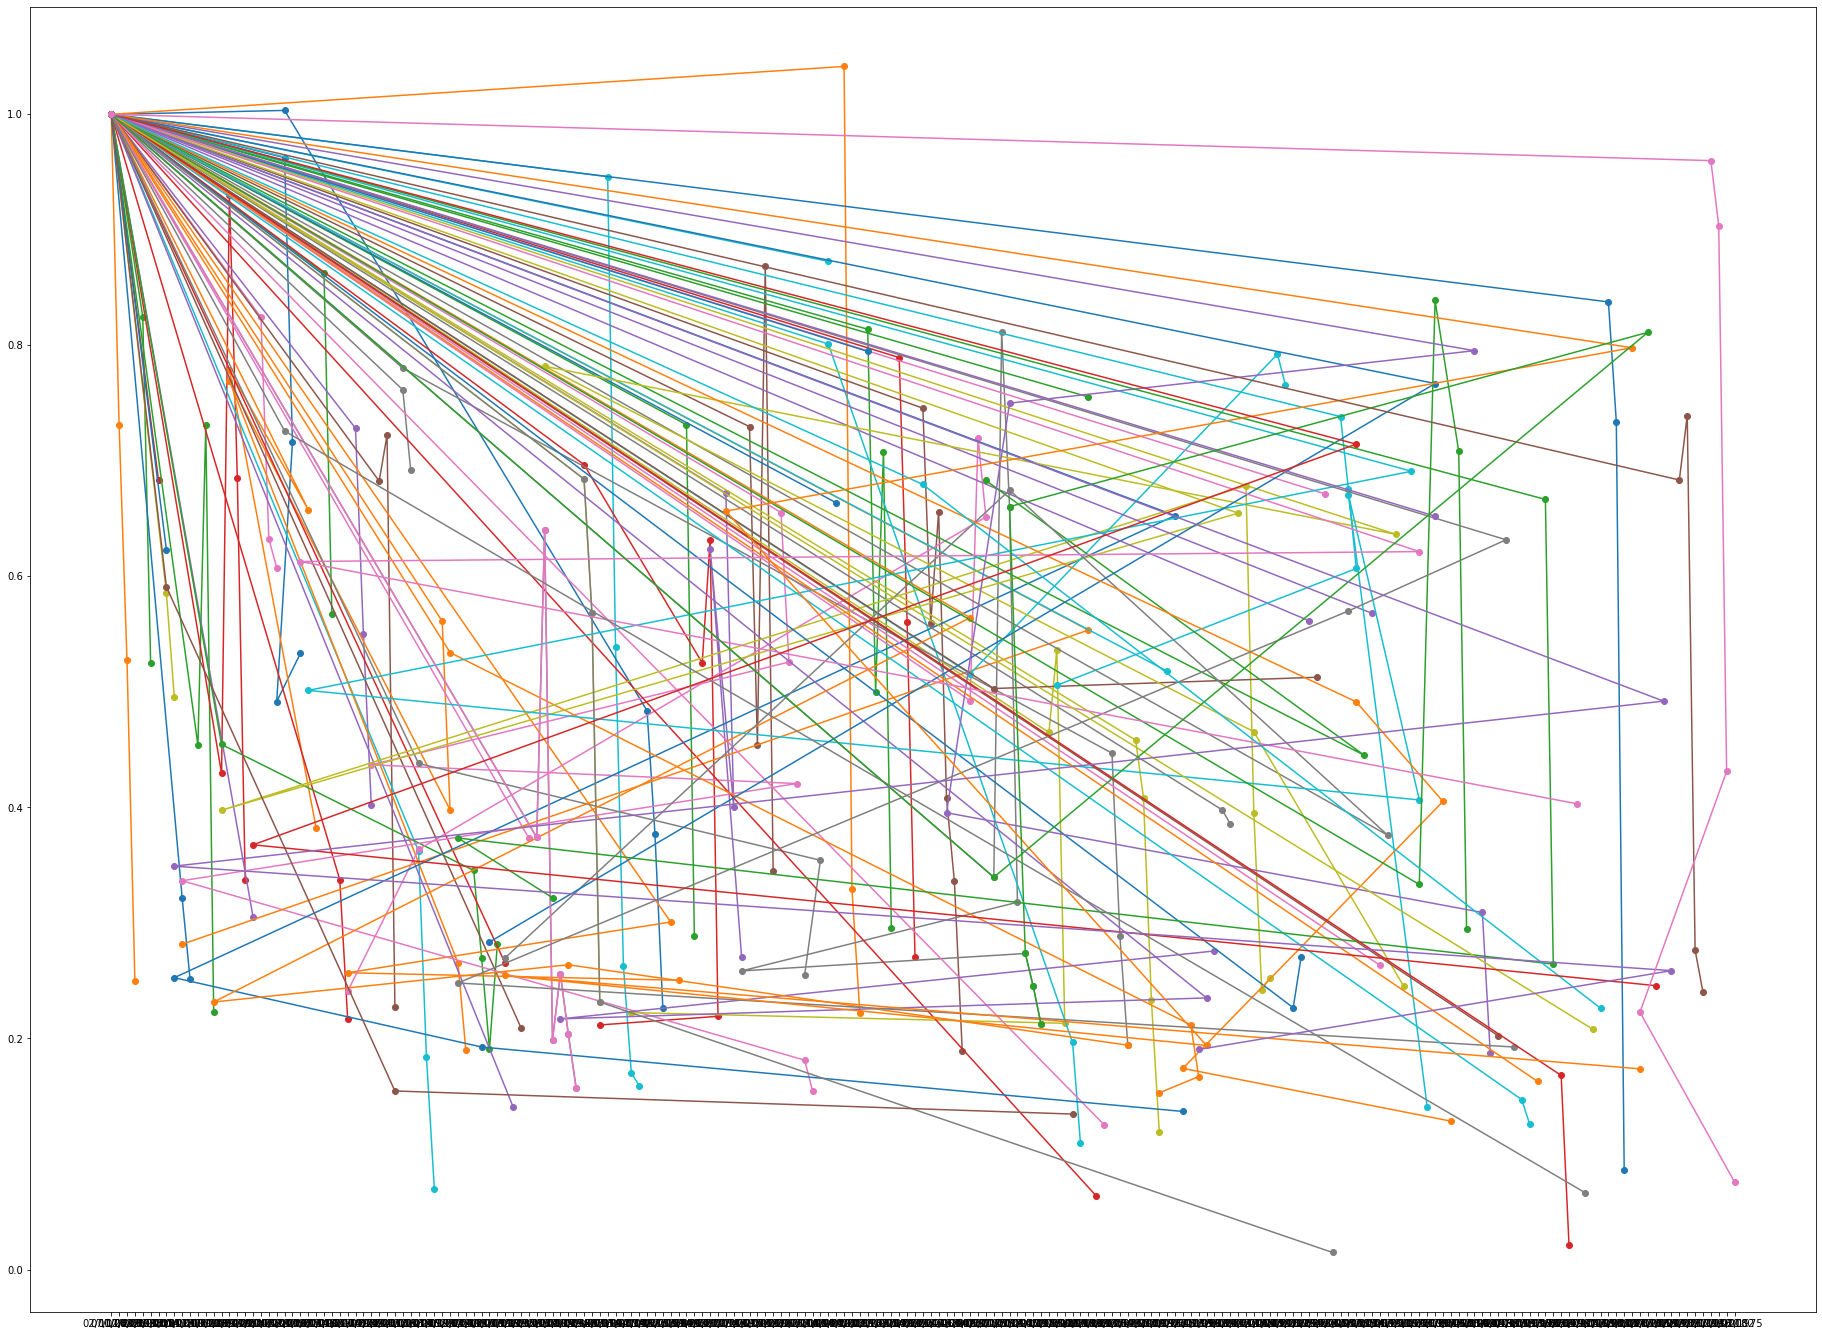

                            address  02/01/2022  12/01/2021  11/01/2021  \
0           12688 Chapman Ave #3313         1.0         NaN         NaN   
1                 237 California Ct         1.0         NaN         NaN   
2         2550 San Gabriel Way #301         1.0         NaN         NaN   
3    23412 Pacific Park Dr Unit 12C         1.0         NaN         NaN   
4           12688 Chapman Ave #3102         1.0         NaN         NaN   
..                              ...         ...         ...         ...   
124           5407 Brittany Way #11         1.0         NaN         NaN   
125                      115 Timbre         1.0         NaN         NaN   
126               975 Cottonwood Ct         1.0         NaN         NaN   
127           6220 Plymouth Ct #106         1.0         NaN         NaN   
128        17760 Palo Verde Ave #27         1.0         NaN         NaN   

     10/01/2021  09/01/2021  08/01/2021  04/01/2021  12/01/2020  10/01/2020  \
0           NaN     

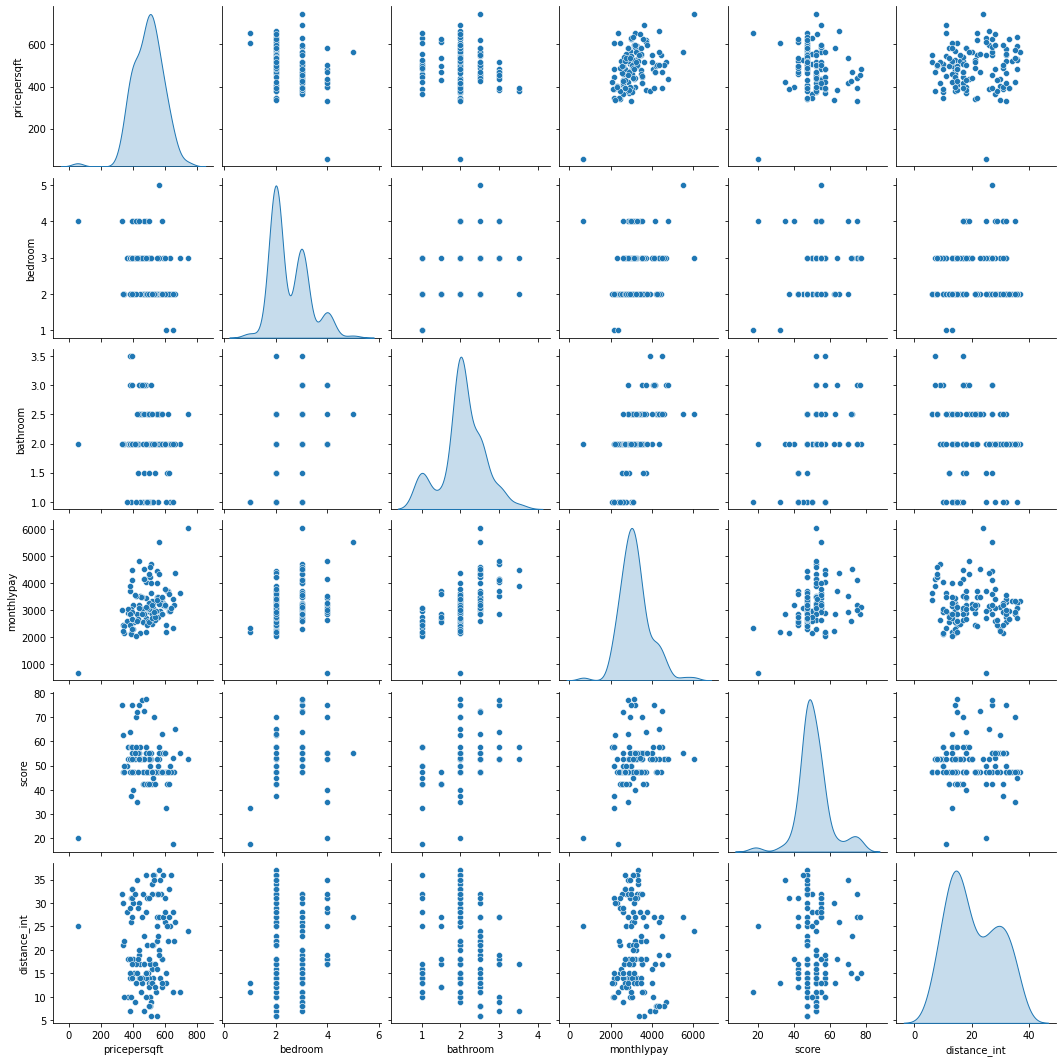

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting library 
import seaborn as sns # data visualization library 
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# rename_cols
# parameter: c - columns 
# replaces the column names with the prefix history-
# and adds the appropriate dates to the history 
def rename_cols(c): 
    if c.startswith("history-"):
        return re.sub(r'([0-9]{2})([0-9]{4})', r'\1/01/\2', c.replace("history-", ""))
    return c

# splitSerToArr
# parameter: s - series
# splits a pandas series into an array 
def splitSerToArr(s):
    return [s.index, s.to_numpy()]

# normSplitSerToArr
# parameters: s - series 
# d - denominator for the series 
# "normalizes" a series by dividing the value by a constant
def normSplitSerToArr(s, d):
    return [s.index, s.to_numpy()/d]

def meanNormSplitSerToArr(s, d):
    return [s.index, s.to_numpy()/d]

df = pd.read_csv('/kaggle/input/north-oc-housing-data/north_county_oc - Sheet1.csv')
#making a copy of the dataframe
# Dropping the rows with the value of n/a for the address
data = df.dropna(axis=0, how='all', thresh=None, subset=['address'], inplace=False).copy()
# Rename the columns using the function rename_cols
data.rename(columns=lambda c: rename_cols(c), inplace=True)
# Drop duplicates 
data.drop_duplicates(subset=['address', 'city', 'state', 'zip'])

##checking for all the null values
data.isnull().sum()

##summary statistics of quantitative variables
data.describe()

##looking at horsepower box plot
# sns.boxplot(x=data['points'])

## adding a price column
## this combines the following columns 
## currentestimate is first since it assumes that 
## the property has not been sold. Sales price is for a 
## recently sold property. Last is the asking price since
## the property is on the market
data['price'] = data['currentestimate'].combine_first(data["saleprice"]).combine_first(data["askingprice"])

data['pricepersqft'] = data['price']/data['squareft']

#sns.boxplot(x=data['pricepersqft'])

pricehistory = data.loc[:, ~data.columns.isin(['type', 'firstfloorentry', 'yearbuilt', 'newhousing', 'distance', 'distance_int', 'myscore', 'score', 'mls', 'rate', 'insurance', 'above2300', 'redfin', 'id', 'city', 'zip', 'squareft', 'monthlypay', 'bedroom', 'bathroom', 'hoa', 'state', 'currentestimate', 'askingprice', 'saleprice', 'datesold', 'salesdiff', 'points', '55plus', 'lottransfer', 'stronglyconsider', 'buy', 'pricepersqft'])].rename(columns={"price": "02/01/2022"})
# shift column of recent price to second position
move_date = pricehistory.pop('02/01/2022')
pricehistory.insert(1, '02/01/2022', move_date)
pricecolumns = pricehistory.columns.delete(0)

# Replace NaN with None
pricehistory = pricehistory.where(pd.notnull(pricehistory), None)
# Remove outliers using the latest price
pricehistory = pricehistory[(np.abs(stats.zscore(pricehistory['02/01/2022'])) < 3)]

# normalize pricehistory
normalized_pricehistory=(pricehistory-pricehistory.mean())/pricehistory.std()

plot1 = plt.figure(1, figsize=(32,24))
for index, row in pricehistory.iterrows():
    address = row.pop('address')
    # dropna drops the value of None from the series 
    plt.plot(*splitSerToArr(row.dropna()), linestyle='-', marker='o',label=address)
    
normpricehistory = pd.DataFrame(columns=pricehistory.columns)

# Create second normalized plot by the current selling price 
# or recent sold price of the home (found in the first column)
plot2 = plt.figure(2, figsize=(32,24))
for index, row in pricehistory.iterrows():
    address = row.pop('address')
    # dropna drops the value of None from the series 
    plt.plot(*normSplitSerToArr(row.dropna(), row[0]), linestyle='-', marker='o',label=address)
    # save the data to the normpricehistory data frame
    normpricehistory.loc[index] = row / row[0]
    normpricehistory.loc[index, 'address'] = address

plt.show()

## Normalized price history
normpricehistory.to_csv("./normpricehistory.csv")
print(normpricehistory)

##pairplots to get an intuition of potential correlations
data['monthlypay'] = data['monthlypay'].replace('[\$,]', '', regex=True).astype(float)

sns.pairplot(data[["pricepersqft", "bedroom", "bathroom", "monthlypay", 'score', 'distance_int']], diag_kind="kde")
print(data)
print("Saving data to a file")
data.to_csv("./data.csv")